In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
print("Using torch", torch.__version__)

import gym

Using torch 1.12.1+cu102


In [56]:
# each layer has a unique min weight size, std_dev, layer size and transmitter value
# to provide a diversity of transmitter values, multiple layers should be used for each layers output
class Layer:
    
    def __init__(
            self, 
            init_weight_std_dev, 
            weight_step_size,
            fire_tracker_decay_rate,
            input_size, 
            layer_size, 
            transmitter_value,
            activation_value):
                
        # store layer configs
        self.std_dev = init_weight_std_dev
        self.weight_step_size = weight_step_size
        self.fire_tracker_decay_rate = fire_tracker_decay_rate
        self.input_size = input_size
        self.layer_size = layer_size
        self.transmitter_value = transmitter_value
        self.activation_value = activation_value
        
        # create initial values for neuron level values
        self.healths = torch.ones(layer_size)
        self.fire_trackers = torch.zeros(layer_size)
        self.counters = torch.zeros(layer_size)   
        
        # initialize weights with std_dev passed
        self.weights = torch.zeros((input_size, layer_size))
        nn.init.normal_(self.weights, std=self.std_dev) 
                
    def eval(self, input_tensor, layer_env_reward):
        # update weights from last steps reward
        print("Updating healths with reward:", layer_env_reward)
        print("healths:", self.healths)
        print("fire_trackers:", self.fire_trackers)
        self.healths += self.fire_trackers * self.weight_step_size * layer_env_reward
        self.fire_trackers *= self.fire_tracker_decay_rate
        print("healths:", self.healths)
        print("fire_trackers:", self.fire_trackers)
        
        unhealthy_neurons = self.healths <= 0
        self.healths += unhealthy_neurons
        print("unhealthy_neurons:", unhealthy_neurons)
        print("healths:", self.healths)
        
        print("weights:", self.weights)
        weight_update = torch.zeros((self.input_size, self.layer_size))
        nn.init.normal_(weight_update, std=self.std_dev) 
        weight_update = weight_update * unhealthy_neurons
        self.weights += weight_update

        print("new weights:", self.weights)
        
        print("input:", input_tensor)
        activated_weights = self.weights > 0 
        activated_weights = torch.ones(self.layer_size) * activated_weights
        print("activated_weights:", activated_weights, activated_weights.shape, input_tensor.shape)
        raw_output = torch.matmul(input_tensor, activated_weights)
        print("raw_output:", raw_output)
        output_bool = raw_output > self.activation_value
        print("output_bool:", output_bool)
        self.fire_trackers += output_bool
        print("fire_trackers:", self.fire_trackers)
        # maybe just set to 0? maybe never can go below 0 either?
        #self.counters -= self.activation_value * output_bool
        #print("counters:", self.counters)
        output = output_bool * self.transmitter_value
        print("output:", output)
        return output
    
    def reset(self):
        self.fire_trackers = torch.zeros(self.layer_size)
        self.counters = torch.zeros(self.layer_size)   
        

class Agent:
    
    def __init__(self, seed, layers):
        torch.manual_seed(seed)
        self.layers = layers
    
    def step(self, input_state):
        input_tensor = input_state

        for i, layer in enumerate(self.layers):
            layer_output = layer.eval(input_tensor)
            
        output = input_tensor
        output_fires = output >= 1
        value, action = torch.max(output, axis=0)
        action = action.item() 
        if value == 0:
            action = None
            
        print("output", output, "action", action)
        return action
    
    def reset(self):
        for layer in self.layers:
            layer.reset()


Updating healths with reward: 0
healths: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],
        [-0.0086,  0.0315,  0.0043,  0.0033, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033,  0.0130]])
new weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],


output_bool: tensor([False, False])
fire_trackers: tensor([0., 0.])
output: tensor([0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 0.8700, 1.0000, 0.8700, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8700])
fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
healths: tensor([1.0000, 0.8600, 1.0000, 0.8600, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8600])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.8600, 1.0000, 0.8600, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8600])
weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],
        [-0.0086,  0.0315,  0.0043,  0.0033, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033,  0

output_bool: tensor([False,  True, False,  True, False, False, False, False, False,  True])
fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
Updating healths with reward: 0
healths: tensor([1.0000, 1.0000, 0.7300, 0.7300, 1.0000, 0.7300, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.7300, 0.7300, 1.0000, 0.7300, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.7300, 0.7300, 1.0000, 0.7300, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  8.9663e-03,  9.5063e-03, -5.2753e-03,
          9.6242e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -3.7743e-03,  1.32

output: tensor([-0., -0., -1., -1., -0., -1., -0., -0., -0., -0.])
Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -

unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.4500, 0.4500, 1.0000, 0.4500, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  8.9663e-03,  9.5063e-03, -5.2753e-03,
          9.6242e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -3.7743e-03,  1.3207e-02, -5.7232e-03,
         -2.1667e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  9.3779e-03,  9.7805e-03, -1.7226e-02,
          7.9725e-04, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  8.9663e-03,  9.5063e-03, -5.2753e-03,
          9.6242e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -3.7743e-03,  1.3207e-02, -5.7232e-03,
         -2.1667e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.775

fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
healths: tensor([1.0000, 0.3100, 1.0000, 0.3100, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3100])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.3100, 1.0000, 0.3100, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.3100])
weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],
        [-0.0086,  0.0315,  0.0043,  0.0033, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033,  0.0130]])
new weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0

fire_trackers: tensor([0., 0.])
output: tensor([0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 0.1900, 1.0000, 0.1900, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1900])
fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
healths: tensor([1.0000, 0.1800, 1.0000, 0.1800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1800])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.1800, 1.0000, 0.1800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1800])
weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],
        [-0.0086,  0.0315,  0.0043,  0.0033, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033,  0.0130]])
new weights: tensor([[ 0.00

raw_output: tensor([0., 0.])
output_bool: tensor([False, False])
fire_trackers: tensor([0., 0.])
output: tensor([0., 0.])
Updating healths with reward: 0
healths: tensor([1.0000, 0.1000, 1.0000, 0.1000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 0.1000, 1.0000, 0.1000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.1000, 1.0000, 0.1000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.1000])
weights: tensor([[ 0.0084,  0.0094, -0.0122,  0.0077, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0022],
        [ 0.0035, -0.0051, -0.0025, -0.0023,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0017],
        [-0.0086,  0.0315,  0.0043,  0.0033, -0.0167, -0.0117,  0.0064,  0.

output_bool: tensor([False,  True, False,  True, False, False, False, False, False, False])
fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.9900, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.9800, 0.9900, 1.0000, 0.9800, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.9800, 0.9900, 1.0000, 0.9800, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -2.1053e-03,  6

fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.8500, 0.9900, 1.0000, 0.8500, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.8400, 0.9900, 1.0000, 0.8400, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.8400, 0.9900, 1.0000, 0.8400, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -2.1053e-03,  6.6704e-03, -5.7232e-03,
         -1.4146e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482

healths: tensor([1.0000, 0.7100, 1.0000, 0.7100, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.7100, 1.0000, 0.7100, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
weights: tensor([[ 0.0084,  0.0082, -0.0122,  0.0175, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0142, -0.0025, -0.0054,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0062],
        [-0.0086,  0.0453,  0.0043,  0.0140, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033, -0.0023]])
new weights: tensor([[ 0.0084,  0.0082, -0.0122,  0.0175, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0142, -0.0025, -0.0054,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0062],
        [-0.0086,  0.0453,  0.0043,  0.0140, -0.0167, -0.0

Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.5900, 0.9900, 1.0000, 0.5900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.5800, 0.9900, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.5800, 0.9900, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -2.1053e-03,  6.6704e-03, -5.7232e-03,
         -1.4146e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.1311e-02, -4.8638e-03, -1.7226e-02,
          1.2013e-02, -7.0924e-03, -1.39

output: tensor([0., 0.])
Updating healths with reward: 0
healths: tensor([1.0000, 0.4700, 1.0000, 0.4700, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 0.4700, 1.0000, 0.4700, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.4700, 1.0000, 0.4700, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
weights: tensor([[ 0.0084,  0.0082, -0.0122,  0.0175, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0142, -0.0025, -0.0054,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0062],
        [-0.0086,  0.0453,  0.0043,  0.0140, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033, -0.0023]])
new weights: tensor([[ 0.0084,  0.0082, -0.0122,  0.0175, -0.0

fire_trackers: tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.3500, 0.9900, 1.0000, 0.3500, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.3500, 0.9900, 1.0000, 0.3500, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -2.1053e-03,  6.6704e-03, -5.7232e-03,
         -1.4146e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.1311e-02, -4.8638e-03, -1.7226e-02,
          1.2013e-02, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-

healths: tensor([1.0000, 1.0000, 0.2100, 0.9900, 1.0000, 0.2100, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.2100, 0.9900, 1.0000, 0.2100, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -2.1053e-03,  6.6704e-03, -5.7232e-03,
         -1.4146e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.1311e-02, -4.8638e-03, -1.7226e-02,
          1.2013e-02, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  3.1196e-04, -1.9179e-02, -5.2753e-03,
          3.3194e-03, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
       

fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
       

Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
  

output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: 0
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0

fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0

unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.6000, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  5.2989e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  4.0673e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  1.4671e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  5.2989e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  4.0673e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.775

raw_output: tensor([0., 1.])
output_bool: tensor([False, False])
fire_trackers: tensor([0., 0.])
output: tensor([0., 0.])
Updating healths with reward: 0
healths: tensor([1.0000, 0.4800, 1.0000, 0.4800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 0.4800, 1.0000, 0.4800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.4800, 1.0000, 0.4800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
weights: tensor([[ 0.0084,  0.0167, -0.0122,  0.0017, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0107, -0.0025, -0.0075,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0062],
        [-0.0086,  0.0505,  0.0043,  0.0063, -0.0167, -0.0117,  0.0064,  0.

raw_output: tensor([1., 2., 1., 2., 0., 1., 1., 1., 0., 1.])
output_bool: tensor([False,  True, False,  True, False, False, False, False, False, False])
fire_trackers: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.3700, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.3600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.3600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  5.2989e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.

new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
input: tensor([ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -1., -0.,
        -0., -0., -0., -0., -0., -0.])
activated_weights: tensor([[0., 1.],
        [1., 1.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.],
        [0., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 0.],
        [0., 

fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.0108,  0.0032],
        [-0.0024,  0.0048],
        [-0.0188, -0.0053]])
new weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [

fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.0100, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.0100, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  5.2989e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  4.0673e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  1.4671e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  5.2989e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-

unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.9000, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.775

fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.8000, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0

new weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
input: tensor([1., 0., 1.])
activated_weights: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]) torch.Size([3, 10]) torch.Size([3])
raw_output: tensor([0., 1., 2., 0., 0., 1., 0., 0., 1., 1.])
output_bool: tensor([False, False,  True, False, False, False, False, False, False, False])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with

Updating healths with reward: 0
healths: tensor([1.0000, 0.5800, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 0.5800, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.5800, 1.0000, 0.5800, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
weights: tensor([[ 8.4091e-03,  2.8210e-02, -1.2187e-02,  1.0119e-02, -1.8316e-03,
          4.0780e-03, -9.5351e-03, -1.5298e-02, -2.1722e-04,  5.0577e-03],
        [ 3.5433e-03, -1.3719e-02, -2.4873e-03,  7.0296e-06,  4.0292e-03,
         -1.4652e-02, -1.6685e-02, -1.6609e-02,  2.3935e-02, -6.2350e-03],
        [-8.5598e-03,  6.8552e-02,  4.2526e-03,  7.4043e-03, -1.6700e-02,
         -1.1695e-02,  6.3681e-03,  7.1585e

output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.4800, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.4700, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.4700, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-

output: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.3700, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.3600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.3600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-

fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.2600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.2600, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02, -1.4163e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  2.3228e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  4.1756e-03, -1.9179e-02, -5.2753e-03,
         -3.6567e-

raw_output: tensor([0., 1., 2., 0., 0., 1., 0., 0., 1., 1.])
output_bool: tensor([False, False,  True, False, False, False, False, False, False, False])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
        [-0.0049, -0.0096],
        [-0.0114, -0.0078],
        [ 0.0071,  0.0019],
        [-0.0038, -0.0031],
        [ 0.0113, -0.0069],
        [-0.0130,  0.0121],
        [ 0.0088,  0.0235],
        [-0.

input: tensor([1., 0., 1.])
activated_weights: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]) torch.Size([3, 10]) torch.Size([3])
raw_output: tensor([0., 1., 2., 0., 0., 1., 0., 0., 1., 1.])
output_bool: tensor([False, False,  True, False, False, False, False, False, False, False])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
  

activated_weights: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]) torch.Size([3, 10]) torch.Size([3])
raw_output: tensor([0., 1., 2., 0., 0., 1., 0., 0., 1., 1.])
output_bool: tensor([False, False,  True, False, False, False, False, False, False, False])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: 0
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
        [-0.0025, -0.0051],
     

fire_trackers: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 0.8300, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 0.8300, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9900])
weights: tensor([[ 0.0084,  0.0307, -0.0122,  0.0200, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0156, -0.0025,  0.0157,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0062],
        [-0.0086,  0.0596,  0.0043, -0.0097, -0.0167, -0.0117,  0.0064,  0.0072,
         -0.0033, -0.0023]])
new weights: tensor([[ 0.0084,  0.0307, -0.0122,  0.0200, -0.0018,  0.0041, -0.0095, -0.0153,
         -0.0002,  0.0051],
        [ 0.0035, -0.0156, -0.0025,  0.0157,  0.0040, -0.0147, -0.0167, -0.0166,
          0.0239, -0.0

output: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Updating healths with reward: -0.1
healths: tensor([1.0000, 1.0000, 0.7400, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
healths: tensor([1.0000, 1.0000, 0.7300, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
fire_trackers: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.7300, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  1.5493e-02, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  3.1372e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  1.0258e-02, -4.8638e-

unhealthy_neurons: tensor([False, False, False, False, False, False, False, False, False, False])
healths: tensor([1.0000, 1.0000, 0.6200, 0.9900, 1.0000, 0.9900, 1.0000, 1.0000, 1.0000,
        1.0000])
weights: tensor([[-1.1627e-02, -1.1445e-02,  1.5493e-02, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  3.1372e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.7758e-03,  1.0258e-02, -4.8638e-03, -1.7226e-02,
          4.9121e-03, -7.0924e-03, -1.3935e-02, -8.0176e-03,  1.2148e-04]])
new weights: tensor([[-1.1627e-02, -1.1445e-02,  1.5493e-02, -1.9179e-02, -5.2753e-03,
         -3.6567e-04, -6.5703e-03, -1.0478e-02,  6.7337e-03, -5.2718e-04],
        [-6.8604e-05, -1.2536e-02,  3.1372e-03,  6.6704e-03, -5.7232e-03,
         -2.1759e-02, -5.2416e-03, -1.0834e-03, -1.6863e-03, -1.4482e-03],
        [-2.0529e-02,  5.775

input: tensor([1., 0., 1.])
activated_weights: tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]]) torch.Size([3, 10]) torch.Size([3])
raw_output: tensor([0., 1., 2., 0., 0., 1., 0., 0., 1., 1.])
output_bool: tensor([False, False,  True, False, False, False, False, False, False, False])
fire_trackers: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
output: tensor([-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.])
Updating healths with reward: -0.1
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
healths: tensor([1., 1.])
fire_trackers: tensor([0., 0.])
unhealthy_neurons: tensor([False, False])
healths: tensor([1., 1.])
weights: tensor([[-0.0084,  0.0074],
        [ 0.0047,  0.0065],
        [-0.0119, -0.0012],
        [-0.0074,  0.0099],
        [ 0.0104, -0.0018],
        [ 0.0024,  0.0028],
        [-0.0105, -0.0263],
        [-0.0160,  0.0102],
        [ 0.0073,  0.0146],
  

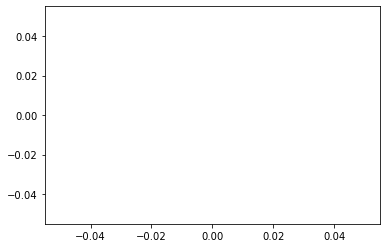

In [58]:
rewards = []
seed = 422 
torch.manual_seed(seed)
# this will make negative weights, make sure weights are positive (sigmoid?)
init_weight_std_dev = .01 
minimum_weight_value = .3
weight_step_size = .1
fire_tracker_decay_rate = 0
counter_decay_rate = .9

pos_symbol_layer = Layer(
                    init_weight_std_dev=init_weight_std_dev, 
                    weight_step_size=weight_step_size,
                    fire_tracker_decay_rate=fire_tracker_decay_rate,
                    input_size=3, 
                    layer_size=10, 
                    transmitter_value=1.0,
                    activation_value=1)

neg_symbol_layer = Layer(
                    init_weight_std_dev=init_weight_std_dev, 
                    weight_step_size=weight_step_size,
                    fire_tracker_decay_rate=fire_tracker_decay_rate,
                    input_size=3, 
                    layer_size=10, 
                    transmitter_value=-1.0,
                    activation_value=1)

output_layer = Layer(
                init_weight_std_dev=init_weight_std_dev, 
                weight_step_size=weight_step_size,
                fire_tracker_decay_rate=fire_tracker_decay_rate,
                input_size=20, 
                layer_size=2, 
                transmitter_value=1.0,
                activation_value=1)

iters = 50

# train on xor
count = 0
for i in range(iters):
    pos_symbol_layer.reset()
    neg_symbol_layer.reset()
    output_layer.reset()
    a = np.array([1, 0])
    input_tensor = torch.from_numpy(a)
    #input_tensor = torch.randint(0, 2, (2,))
    # cat a 1 to the end of the input to act as passive control input 
    effective_input_tensor = torch.cat((input_tensor, torch.ones((1,))))
    action = None
    output_count = 0
    reward = 0
    while output_count < 10:
        pos_layer_out = pos_symbol_layer.eval(effective_input_tensor, reward)
        neg_layer_out = neg_symbol_layer.eval(effective_input_tensor, reward)
        
        concatted_symbol_outs = torch.cat((pos_layer_out, neg_layer_out))
        output = output_layer.eval(concatted_symbol_outs, reward)

        value, action = torch.max(output, axis=0)
        action = action.item() 
        if value == 0:
            action = None
        
        output_count += 1
        if action == None:
            reward = -.1
        else:
            time_steps = 0
            
            input_sum = torch.sum(input_tensor)
            
            # output should be false, or index 0
            if input_sum == 0 or input_sum == 2:
                if output[0] == 1 and output[1] == 0:
                    reward = 1
                else:
                    reward = -1
            else:
                if output[0] == 0 and output[1] == 1:
                    reward = 1
                else:
                    reward = -1
                
            if i % 1000 == 0:
                print("input:", input_tensor, "output:", output, "reward:", reward)
            
            rewards.append(reward)
            break


print("accuracy: ", sum(rewards) / (output_count))
plt.cla()
plt.plot(rewards)
plt.show()